## Load necessary modules

In [1]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import pandas as pd

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


## Load RetinaNet model

In [2]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = os.path.join('/data/a2301133/RetinaNet/snapshots', 'resnet50_csv_25.h5')

# load retinanet model
# model = models.load_model(model_path, backbone_name='resnet50')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
model = models.load_model(model_path, backbone_name='resnet50', convert=True)

# print(model.summary())

In [3]:
# load label to names mapping for visualization purposes
# labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}
labels_to_names = {}
with open("tt100k_classmapping.txt", "rb") as f:
    for line in f:
        data = line.strip().split(',')
        labels_to_names[int(data[1])] = data[0]
f.close()

## Run detection on example

('processing time: ', 0.18480706214904785)


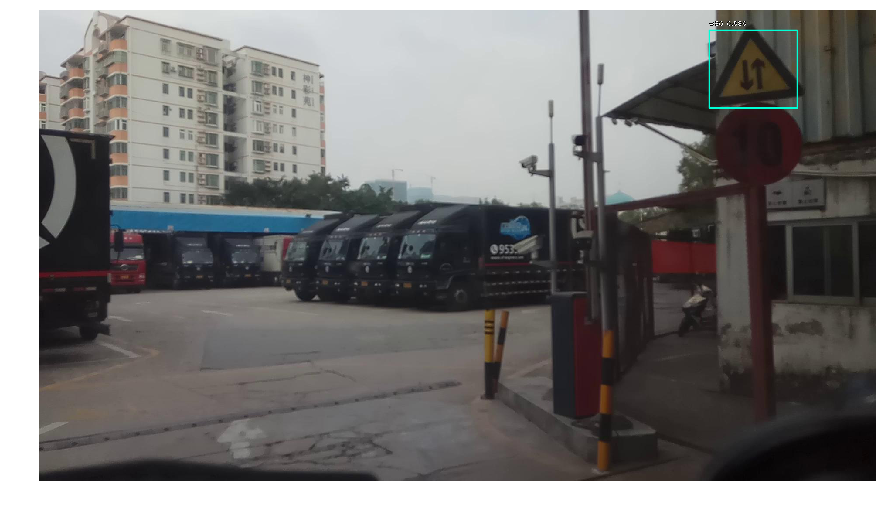

('processing time: ', 0.18299198150634766)


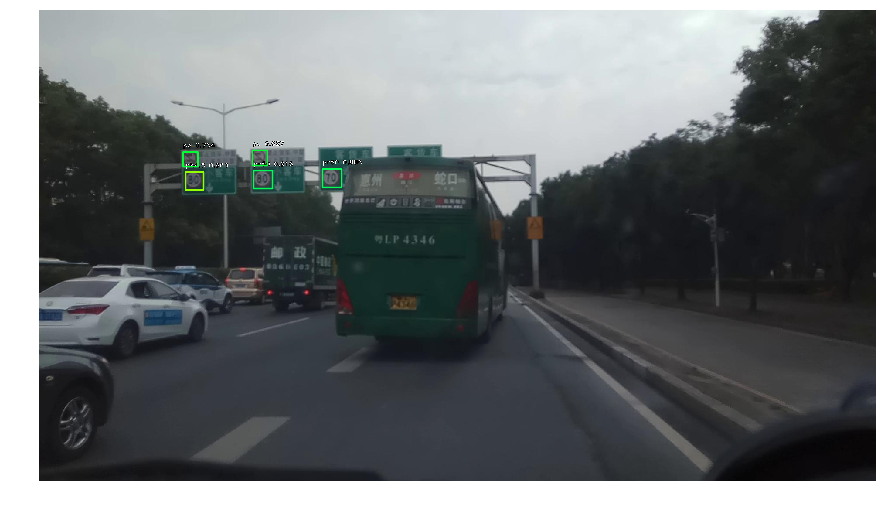

('processing time: ', 0.17865514755249023)


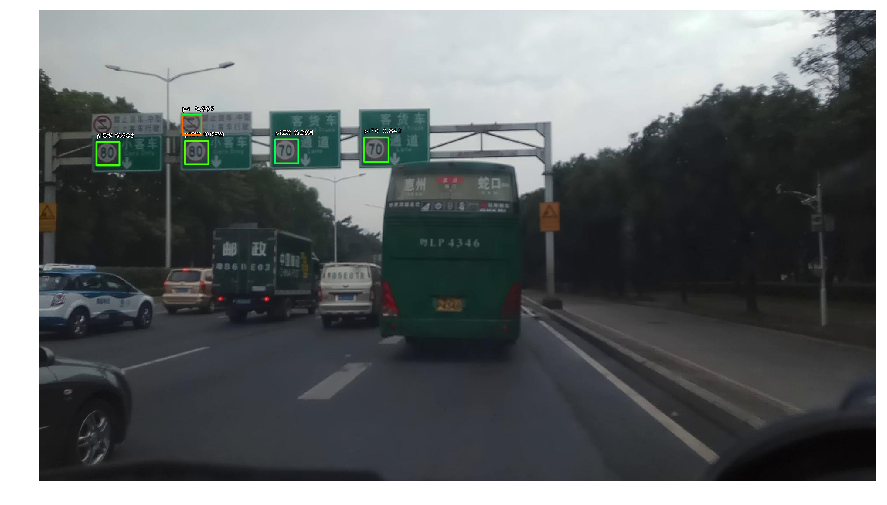

('processing time: ', 0.18111085891723633)


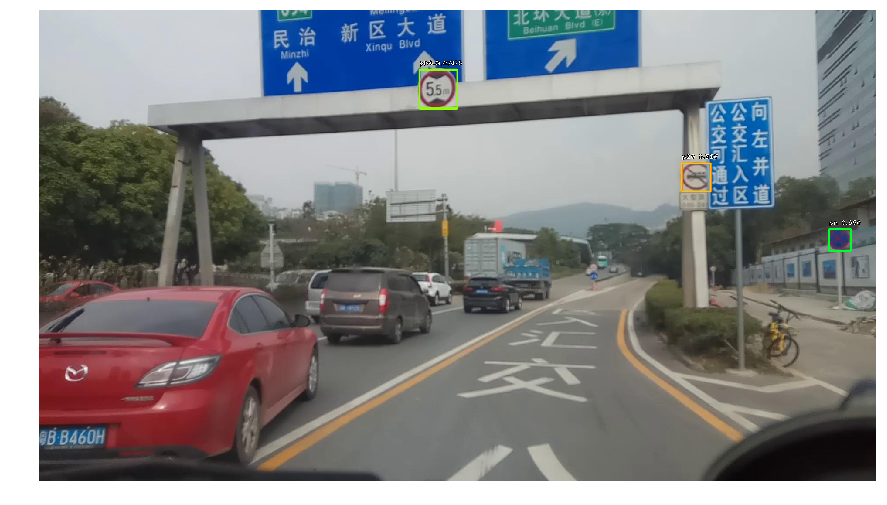

('processing time: ', 0.1815330982208252)


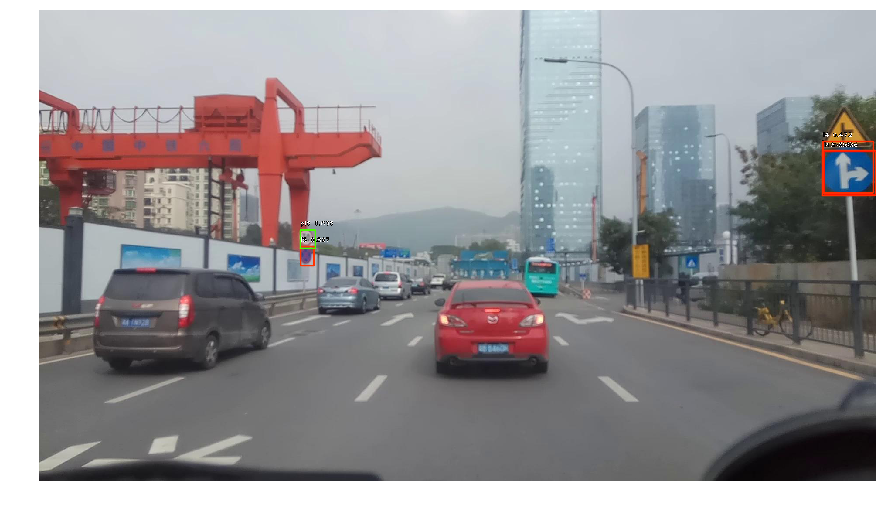

('processing time: ', 0.17679595947265625)


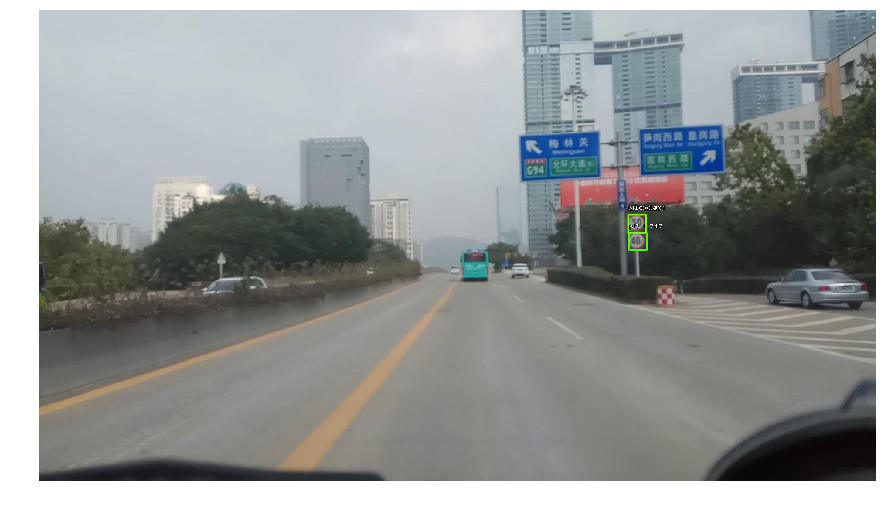

('processing time: ', 0.18309497833251953)


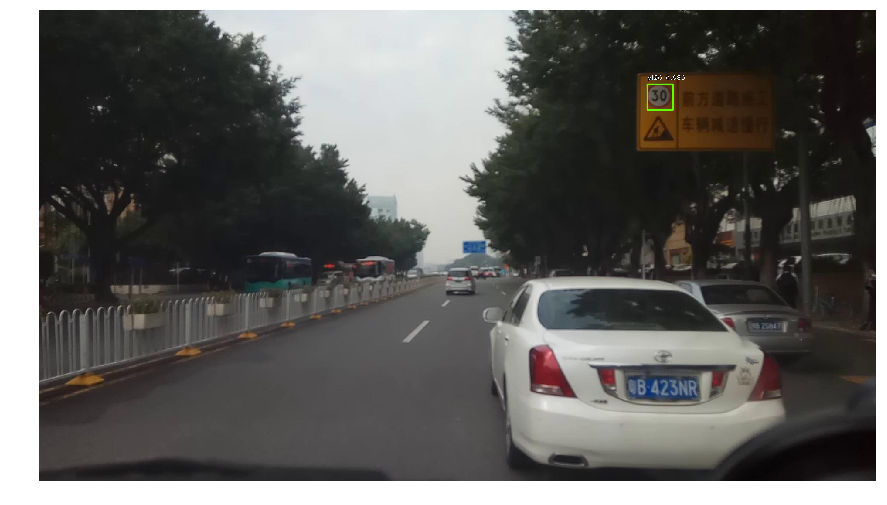

('processing time: ', 0.18832015991210938)


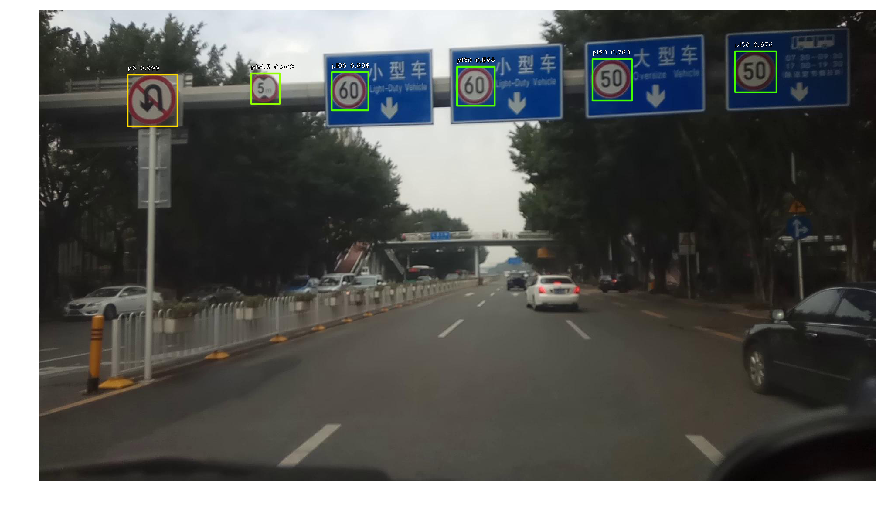

('processing time: ', 0.178422212600708)


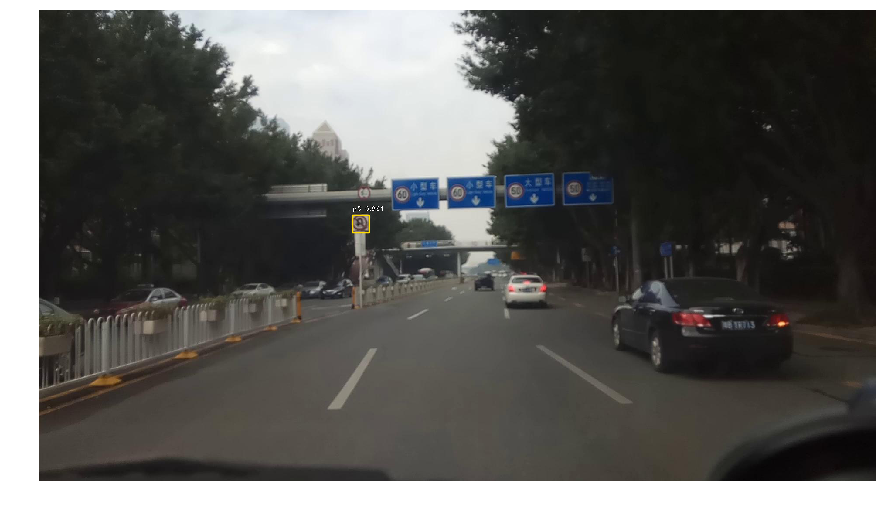

('processing time: ', 0.17723393440246582)


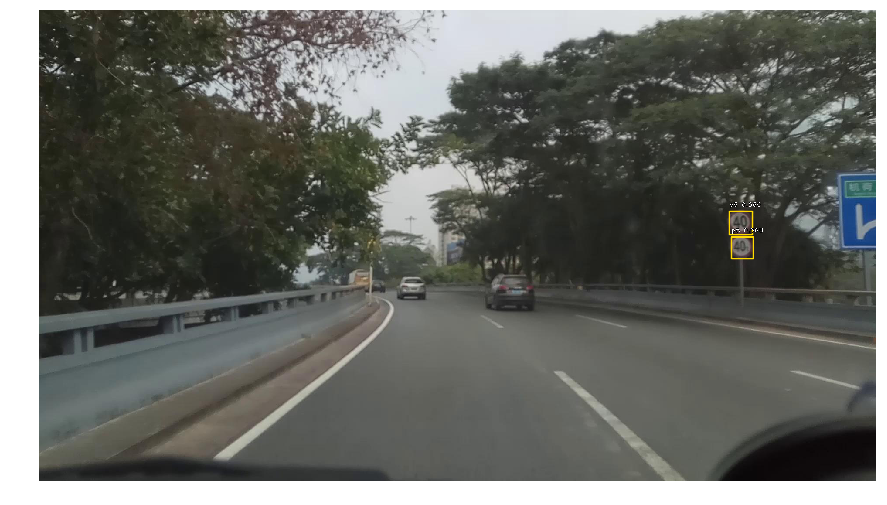

('processing time: ', 0.17884087562561035)


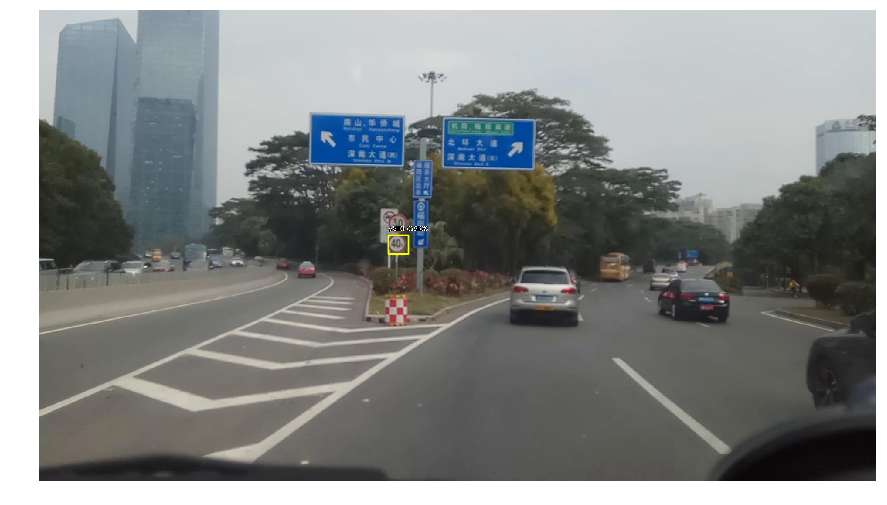

('processing time: ', 0.17685198783874512)


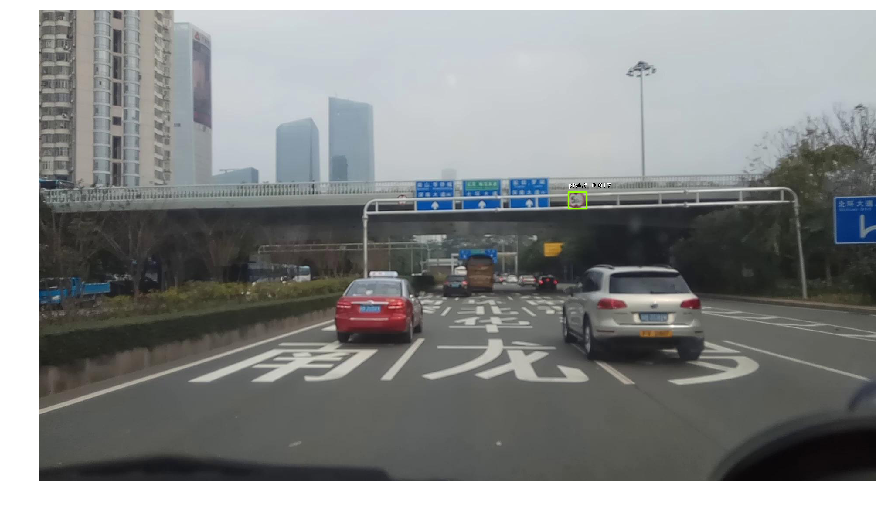

('processing time: ', 0.17936992645263672)


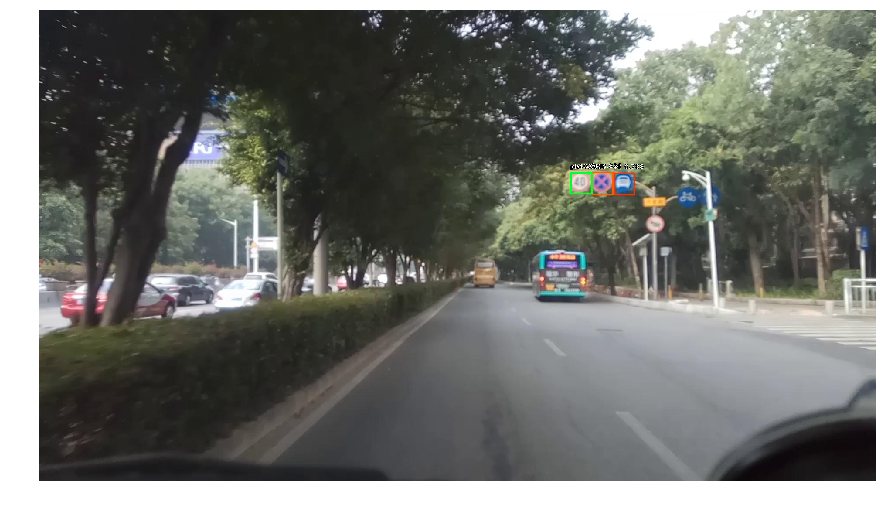

('processing time: ', 0.19266295433044434)


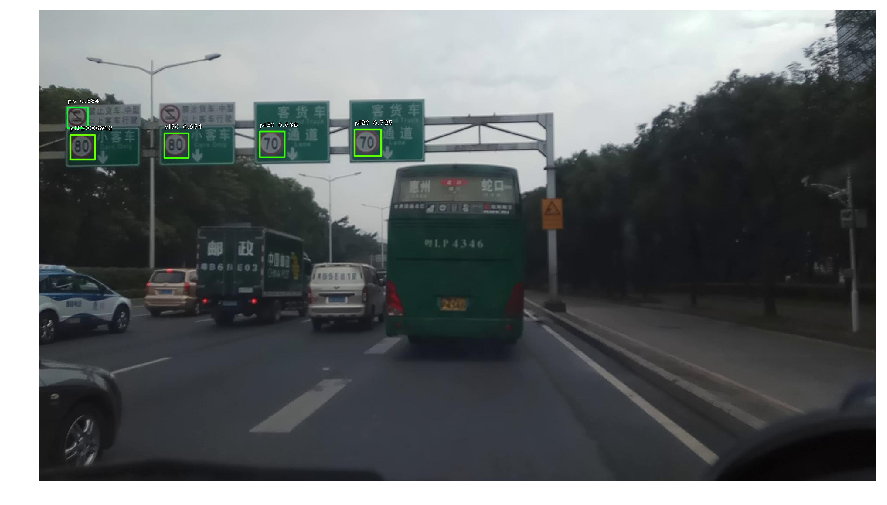

('processing time: ', 0.1808931827545166)


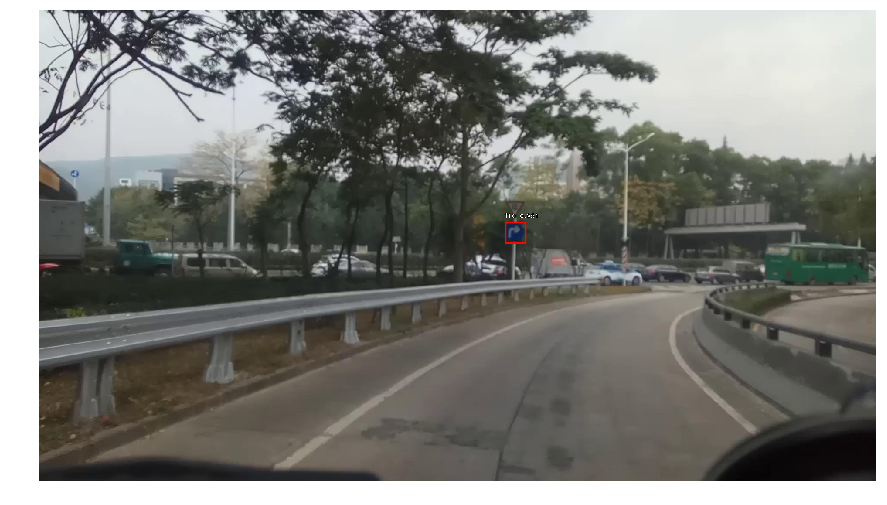

('processing time: ', 0.18222498893737793)


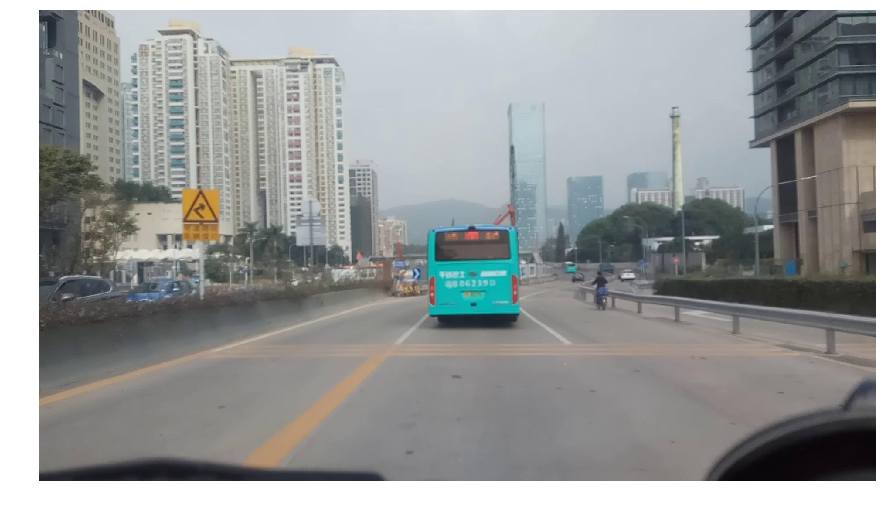

('processing time: ', 0.17990803718566895)


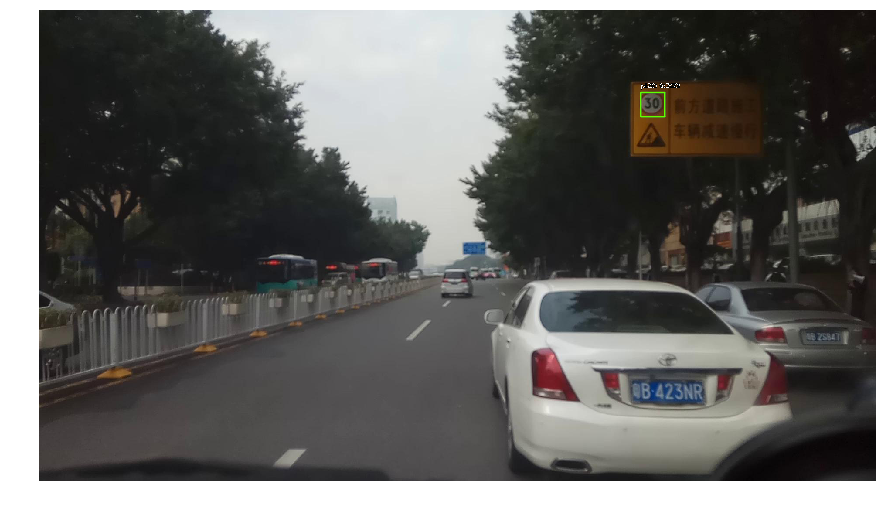

('processing time: ', 0.17993497848510742)


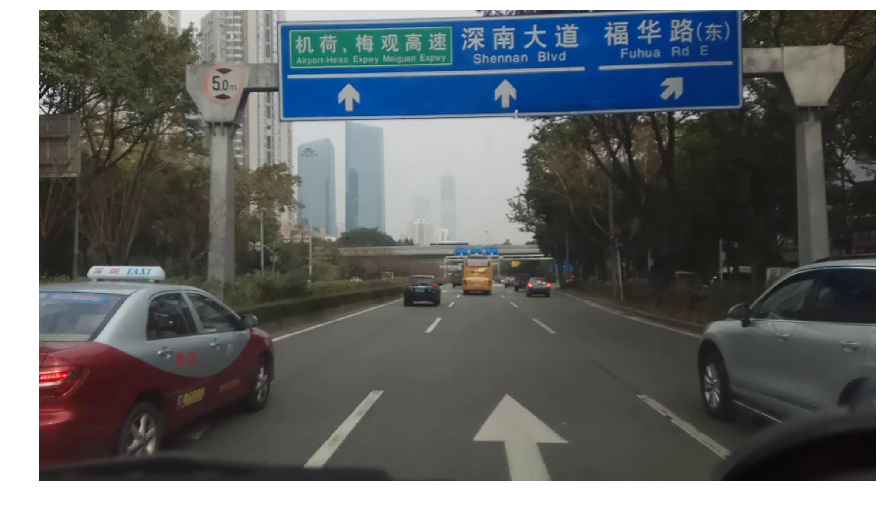

('processing time: ', 0.18331408500671387)


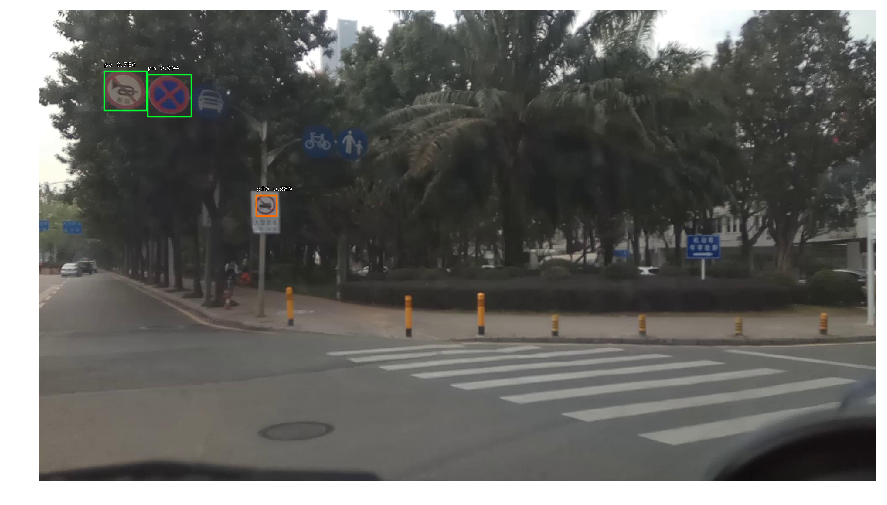

('processing time: ', 0.18421006202697754)


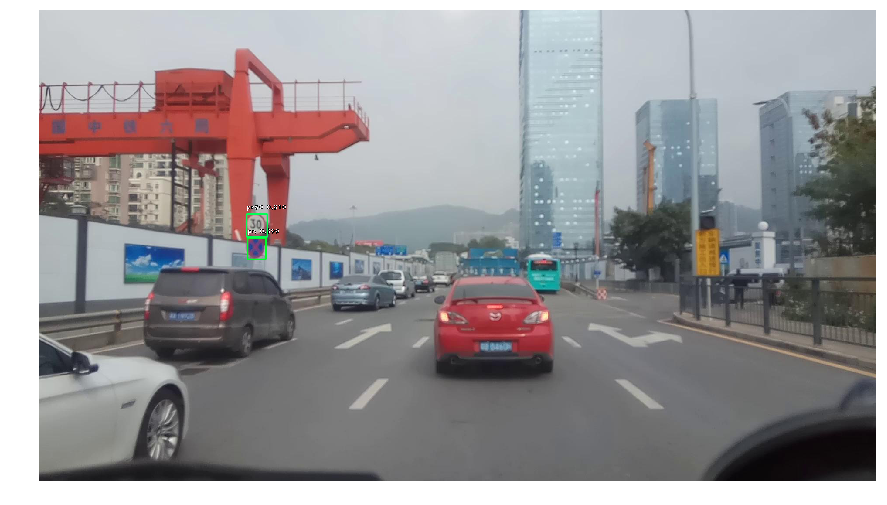

('processing time: ', 0.17962408065795898)


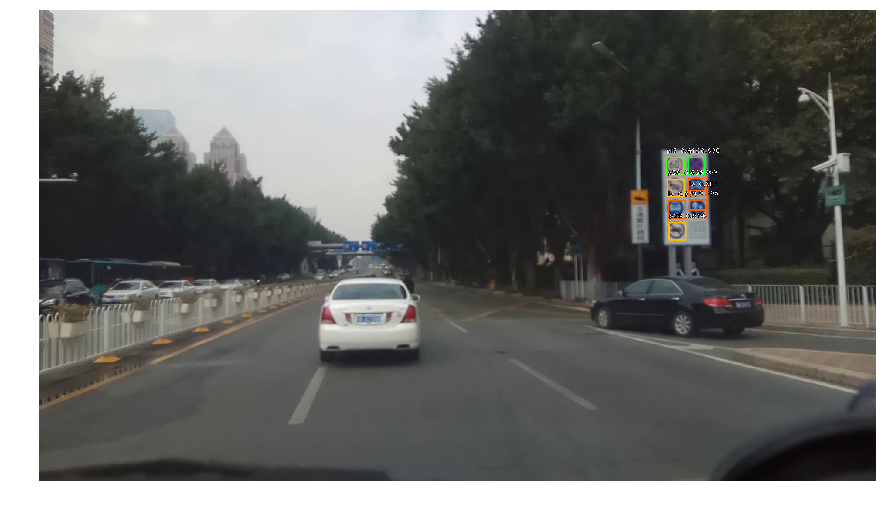

('processing time: ', 0.1906299591064453)


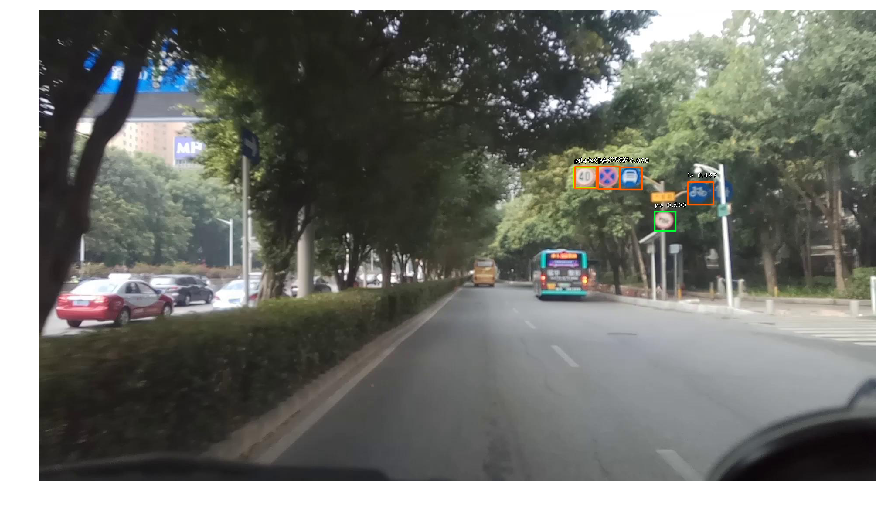

('processing time: ', 0.17318296432495117)


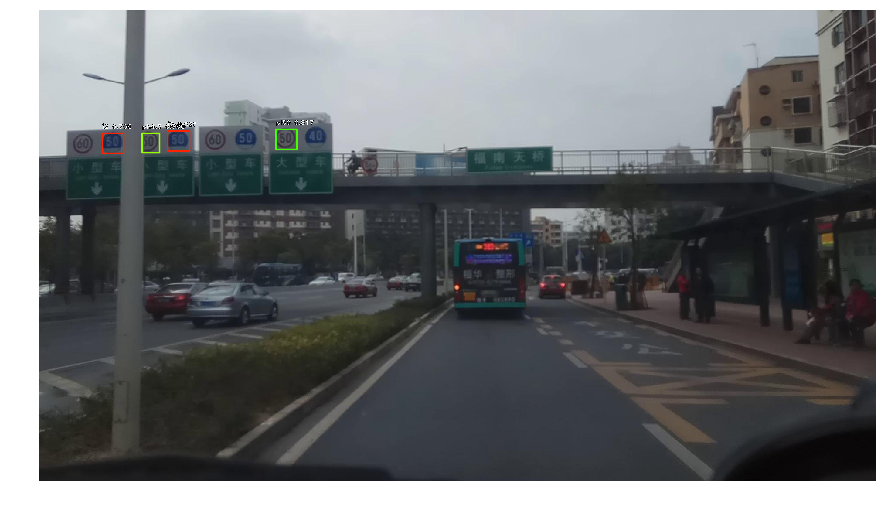

('processing time: ', 0.175767183303833)


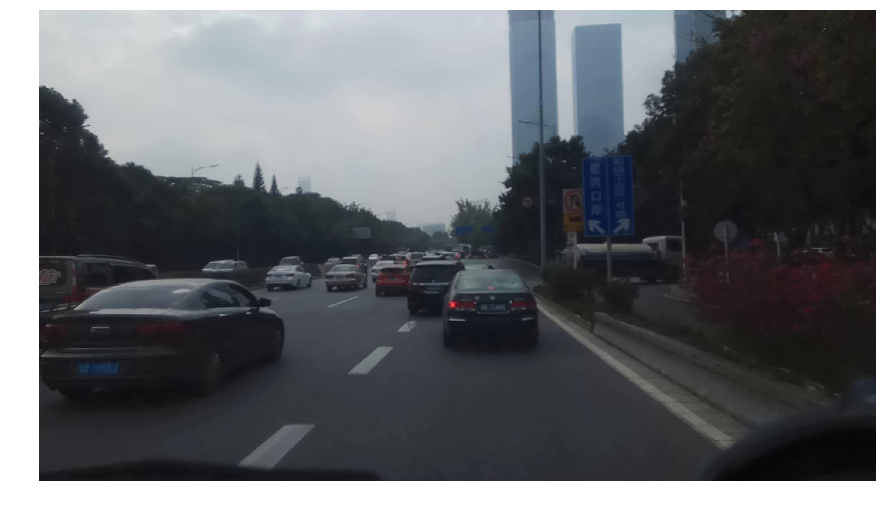

In [5]:
# load image
# image_folder = '/data/a2301133/SF/SF_2018-03-07_10-43-46-770/2018-03-07_10-43-46-770/'
# from random import shuffle
# image_folder = '/data/a2301133/TT100K/data/test/'
# image_folder = '/data/a2301133/SF/SF_2018-03-07_10-43-46-770/2018-03-07_10-43-46-770/'
# file_name = 'SF_770_NEW.txt'
# image_folder = '/data/a2301133/SF/SF_2018-02-06_09-31-29-672/2018-02-06_09-31-29-672_cam/'
# file_name = 'SF_672_NEW.txt'
image_folder = '/data/a2301133/SF/SF_2018-01-26_10-44-55-445/2018-01-26_10-44-55-445_cam/'
file_name = 'SF_445_NEW.txt'

data = pd.read_csv(image_folder + file_name, sep = "\t", header = 0)
data = data[['File','X','Y','Width','Height','SignClass']]
# image_files = [x for x in os.listdir(image_folder) if '.jpg' in x]
# shuffle(image_files)
# image_files = [image_files[i] for i in xrange(len(image_files)) if i <= 10]

for i in range(len(data) / 50):
    i *= 50
    image = read_image_bgr(image_folder + data.iloc[i][0])
    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # correct for image scale
    boxes /= scale

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < 0.45:
            break

        color = label_color(label)

        b = box.astype(int)
        draw_box(draw, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(draw, b, caption)

    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

In [ ]:
from collections import deque
image_folder = '/data/a2301133/SF/SF_2018-03-07_10-43-46-770/2018-03-07_10-43-46-770/'
file_name = 'SF_770_NEW.txt'
data = pd.read_csv(image_folder + file_name, sep = "\t", header = 0)
data = data[['File','X','Y','Width','Height','SignClass']]
threshold = 0.45
for i in range(3):
    image = read_image_bgr(image_folder + data.iloc[i][0])
    image = preprocess_image(image)
    image, scale = resize_image(image)
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis = 0))
    boxes /= scale
    l_boxes, l_scores, l_labels = [], [], []
    for j in range(len(scores[0])):
        if scores[0][j] <= threshold:
            l_scores = scores[0][0 : j]
            l_boxes = boxes[0][0 : j].astype(int)
            l_labels = labels[0][0 : j]
            break
    for k in range(len(l_labels)):
        print labels_to_names.get(l_labels[k])

In [ ]:
x, y = model.predict_on_batch(np.expand_dims(image, axis=0))